Test on kmeans clustering

In [1]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array([[1, 2,3], [1, 4,3], [1, 0,3],[10, 2,5], [10, 4,5], [10, 0,5]])
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans.cluster_centers_

array([[10.,  2.,  5.],
       [ 1.,  2.,  3.]])

In [49]:
Centers = kmeans.cluster_centers_

test on 3d plot

In [2]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

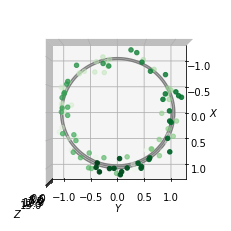

In [69]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')
ax.set_xlabel('$X$', fontsize=10)
ax.set_ylabel('$Y$')
ax.set_zlabel('$Z$')
ax.view_init(90,0)


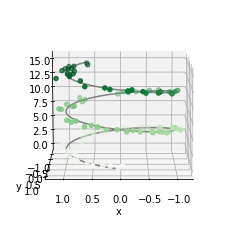

In [54]:
plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')
plt.xlabel("x")
plt.ylabel("y")
ax.view_init(30,-45)
plt.savefig("test.png")
ax.view_init(90,0)
plt.savefig("test2.png")
ax.view_init(10,90)
plt.savefig("test3.png")

read the data by using Lawson's code

In [235]:
from TimeDelay_Neuron_DDF_GaussianForm import *
import Fourier_Power_Spectrum
import plotting_utilities
import save_utilities
import numpy as np
import time
import matplotlib.pyplot as plt
import random
import copy
import glob
from scipy.ndimage import gaussian_filter1d
from mpl_toolkits import mplot3d

import numpy.fft
import math

import os

random.seed(2022)
np.random.seed(2022)

# This code is an edit branching off of Python code
# "User Side Code Separate Train and Test Same Epoch Different CM Auto File Loop"
# on June 6, 2022. I'm using new function definitions to make this file a cleaned up version of that file.

# In[2]:
# modify this
save_and_or_display = "save"

# epoch = None # also called "episode". set to None if not specified
tau_arr = np.array([10])#np.array(range(10, 20)) # math notation: range(2,10) = all integers in bounds [2,9)
D_arr = np.array([10])#np.array(range(2, 10)) # math notation: range(2,10) = all integers in bounds [2,9)
beta_arr = np.array(np.power(10.0,[1]))#np.array(np.power(10.0,range(-3,3))) #range(-3,3) makes array go from 1e-3 to 1e2, not 1e3
R_arr = np.array(np.power(10.0,[-8])) #range(-3,3) makes array go from 1e-3 to 1e2, not 1e3
file_extension = "txt" # string; examples: "atf" or "txt" (case sensitive); don't include period; lowercase

# specify what the neuron names are in the file titles here:
neuron_name_list = [""] # example: ['32425a75', '920061fe'] are two CM neurons from Meliza's 2014 data
Current_units = "pA"
Voltage_units = "mV"
Time_units = "ms"
TT = 0.02 # delta t in Time_units units, time between samples if not specified through loaded files

# Data directory to recursively load data from:
root_directory = "Data2022-50KhZ/" # example: "HVC_biocm_data/simulations/" ; Include the final "/"

# Use only this file:
files_to_evaluate = []#"biocm_phasic_lzo_1_1_10_100_200.mat"] # leave this list empty if you want to evaluate all files in root_directory recursively

do_not_use_list = [] # bad data for RBF training

FPS_xlim= (0,0.175)

fraction_of_data_for_training = 4.0/6.0

# In[3]:

# ======== do not modify below ==========
print("Extensions searched: "+str(save_utilities.glob_extension_case_string_builder(file_extension)))
full_paths_list = glob.glob(root_directory+"**/*."+str(save_utilities.glob_extension_case_string_builder(file_extension)),
                            recursive=True)
neuron_name = "" # leave as "" if no neuron name is found
# Files to ignore within directory:

extensions_with_included_unit_data = ["abf","mat"]

# Code for 2014 Meliza CM data
for i, path in enumerate(full_paths_list):
    full_paths_list[i] = path.replace("\\","/")

print("Full paths list:"+str(full_paths_list))

# In[4]:

for a_path in full_paths_list:
    if file_extension.lower() == "txt":
        if "voltage" in a_path.lower(): # skip files if 'voltage' in filename. Only need to perform rest of this loop when 'current' in filename, to avoid duplicating work.
            continue
    # if "epoch_5" not in a_path:
    #     continue
    # if "Neuron 2" not in a_path:
    #     continue
    last_slash_location = a_path.rfind("/")
    a_filename = a_path[last_slash_location+1:]
    if len(files_to_evaluate)>0 and a_filename not in files_to_evaluate:
        continue
    directory_to_read_input_data = a_path[:last_slash_location+1] # should include the last slash, but nothing past it
    directory_to_store_plots = "plots/" + directory_to_read_input_data + str(a_filename[:-4]) + "/"
    directory_to_store_txt_data = "data_derived/" + directory_to_read_input_data + 'txt_V_I_t/'
    neuron_name = save_utilities.give_name_if_included_in_path(a_path, neuron_name_list)

Extensions searched: [tT][xX][tT]
Full paths list:['Data2022-50KhZ/epoch_1.txt']


In [236]:
if file_extension.lower() in extensions_with_included_unit_data: # primarily .abf and .mat files
    print("File may have included units which will override units specified by user at top of this code.")
    units_list = save_utilities.load_and_prepare_abf_or_mat_data(directory_to_read_input_data, a_filename,
                                                    directory_to_store_txt_data, file_extension)
    Current_units, Voltage_units, Time_units = units_list
    imported_data = np.loadtxt(directory_to_store_txt_data + str(a_filename[:-4]) + "_VIt.txt")

    loaded_V = imported_data[:, 0]
    loaded_I = imported_data[:, 1]
    loaded_t = imported_data[:, 2]
else: # primarily .txt files
    if root_directory=="Data2022-50KhZ/":
        loaded_IV = np.loadtxt(a_path)
        loaded_I = loaded_IV[:, 0]
        loaded_V = loaded_IV[:, 1]
    else:
        if 'current' in a_path:
            voltage_filepath = a_path.replace('current','voltage')
        if 'Current' in a_path:
            voltage_filepath = a_path.replace('Current','Voltage')
        loaded_V = np.loadtxt(voltage_filepath)
        loaded_I = np.loadtxt(a_path)
    loaded_t = TT*np.array(range(len(loaded_V)))


In [7]:
total_num_timesteps_in_data = len(loaded_V)
train_timestep_end = round(total_num_timesteps_in_data*fraction_of_data_for_training) #4/6 for neuron 2 epoch 5, and 5/6 for everything else
tau=10
D=10
    

In [8]:
used_Voltage_train = loaded_V[:train_timestep_end - 1000 + tau*D]

In [9]:
Voltage_test = loaded_V[train_timestep_end:total_num_timesteps_in_data]
Voltage_train = loaded_V[:train_timestep_end]
PreLength = Voltage_test.shape[0]-1000 # - 1000 just to give breathing room
Time_test    = loaded_t[train_timestep_end:total_num_timesteps_in_data]
bias = tau*(D-1)+1
X = Time_test[bias:bias+PreLength]
length = Voltage_train.shape[0]-1000 # - 1000 just to give breathing room


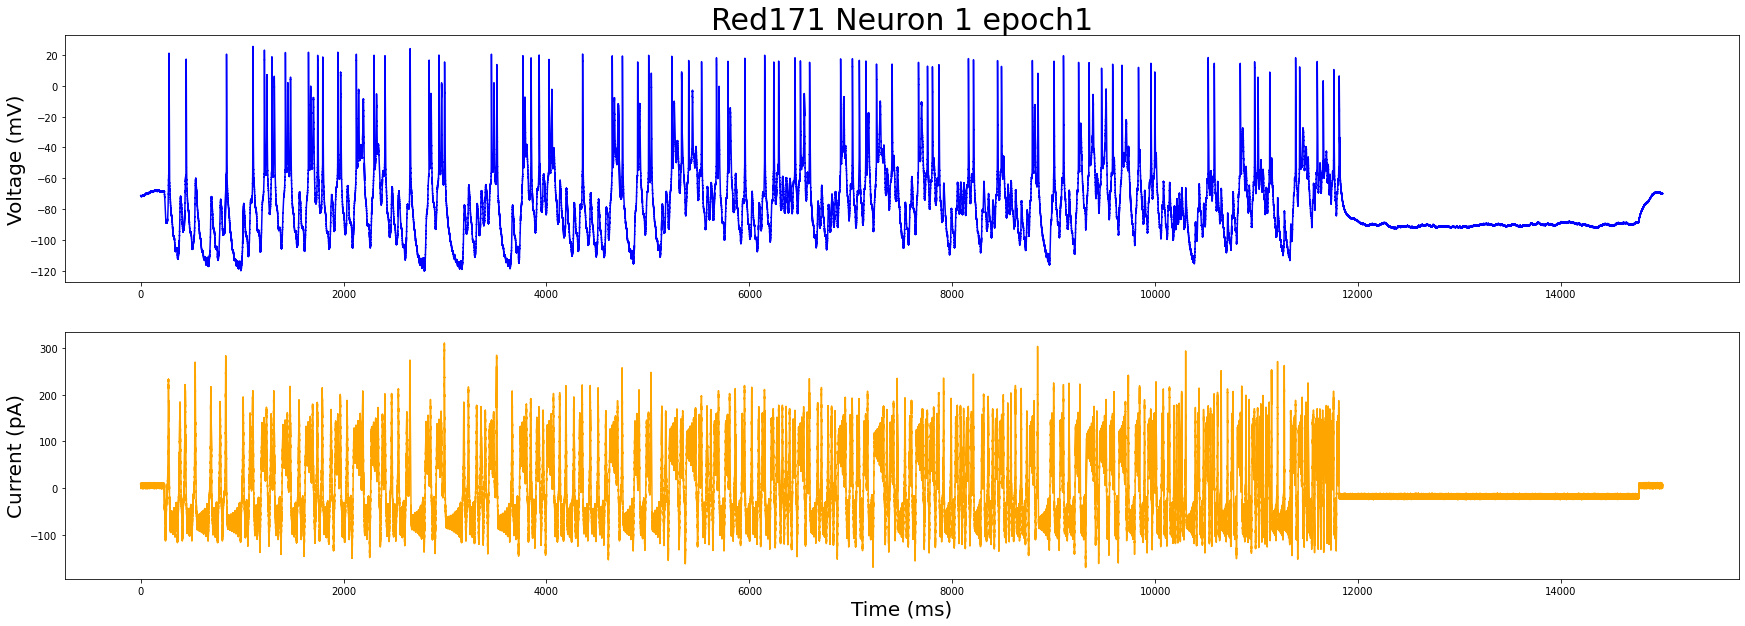

In [199]:
plt.figure(figsize=(30,10))

plt.subplot(2, 1, 1)
plt.plot(loaded_t,loaded_V, color = 'blue')
plt.ylabel('Voltage (mV)',fontsize=20)
plt.title('Red171 Neuron 1 epoch1',fontsize=30)

plt.subplot(2, 1, 2)
plt.plot(loaded_t,loaded_I, color = 'orange')
plt.ylabel('Current (pA)',fontsize=20)
plt.xlabel('Time (ms)',fontsize=20)

plt.savefig('Red171 Neuron 1 epoch1')

In [237]:
Xdata = Voltage_train
NoCenters_no_thresh = 500
# NoCenters_above_thresh = 50
DDF = Gauss()
# Combine centers above threshold with centers determined by kmeans
Center = DDF.KmeanCenter(Xdata,NoCenters_no_thresh,D,length,tau)

Current_train = loaded_I[:train_timestep_end]
stim_train = Current_train

beta = 10#np.array(np.power(10.0,range(-3,3))) #range(-3,3) makes array go from 1e-3 to 1e2, not 1e3
R = 10**(-8)
D = 10
tau = 10

F = DDF.FuncApproxF(Xdata,length,Center,beta,R,D,stim_train,tau)
Pdata = Voltage_test
Current_test = loaded_I[train_timestep_end:total_num_timesteps_in_data]
PredValidation = DDF.PredictIntoTheFuture(F,PreLength,Current_test[bias-1:],Pdata[bias-1-(D-1)*tau:])

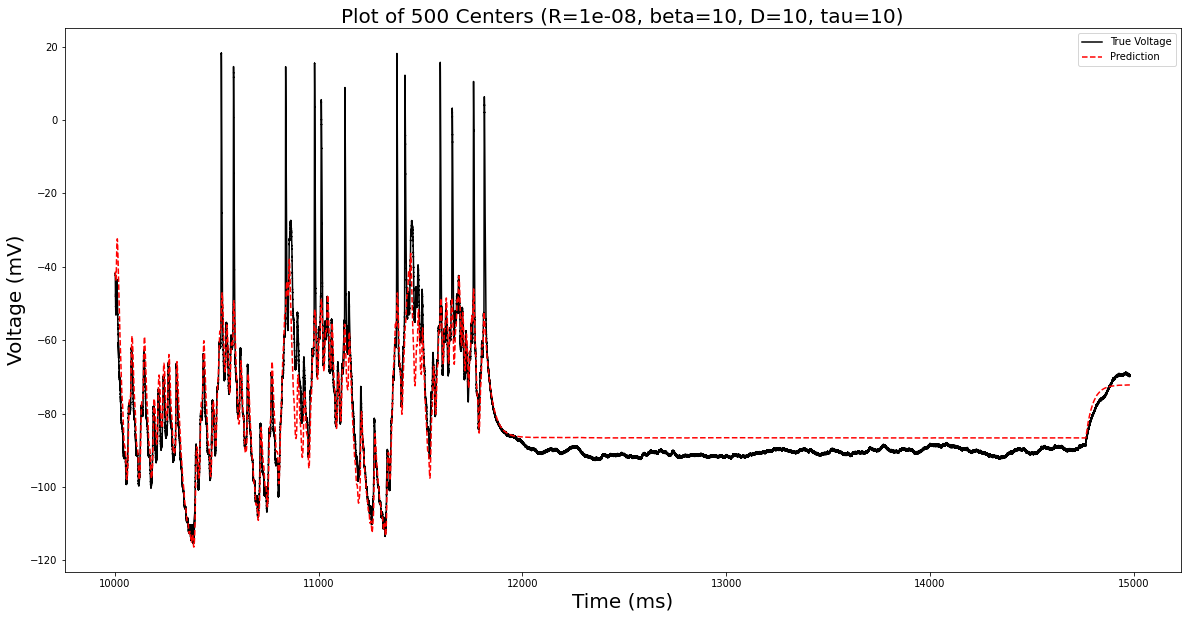

In [201]:
plt.figure(figsize=(20,10))
plt.plot(X,Pdata[bias:bias + PreLength],label = 'True Voltage', color = 'black')
plt.plot(X,PredValidation[tau*(D-1)+1:tau*(D-1)+PreLength+1],'r--',label = 'Prediction')
plt.xlabel('Time ('+str(Time_units)+')',fontsize=20)
plt.ylabel('Voltage ('+str(Voltage_units)+')',fontsize=20)
plt.legend()
plt.title('Plot of 500 Centers (R='+str(R)+', beta='+str(beta)+', D='+str(D)+', tau='+str(tau)+')',fontsize=20)
plt.savefig('500 Centers (R='+str(R)+', beta='+str(beta)+', D='+str(D)+', tau='+str(tau)+')')

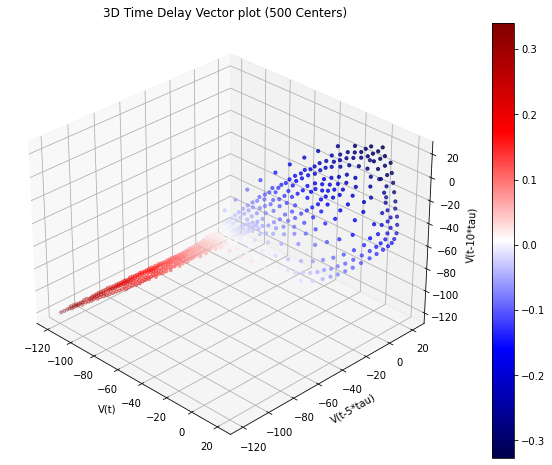

In [202]:
fig=plt.figure(figsize=(18,8))
ax = plt.axes(projection='3d')
weights = DDF.W[:-1]
p=ax.scatter3D(Center[:, 0], Center[:, 4], Center[:, 9], c=weights, cmap=plt.cm.seismic, s=10)
plt.title("3D Time Delay Vector plot (500 Centers)")
ax.set_xlabel("V(t)", fontsize=10)
ax.set_ylabel("V(t-5*tau)", fontsize=10)
ax.set_zlabel("V(t-10*tau)", fontsize=10)
ax.view_init(30,-45)
fig.colorbar(p, ax=ax)
plt.savefig('Weight plot of 500 Centers (R='+str(R)+', beta='+str(beta)+', D='+str(D)+', tau='+str(tau)+')')

In [161]:
def SelectRange(low, high, Xdata):
    fish = []
    for x in Voltage_train:
        if x<high and x>low:
            fish.append(x)
    return np.array(fish)


In [205]:
Xdata2 = SelectRange(-75,-40,Xdata)
NoCenters_no_thresh2 = 100
Center2 = DDF.KmeanCenter(Xdata2,NoCenters_no_thresh2,D,len(Xdata2)-1000,tau)

Centers2 = np.concatenate([Center,Center2])
F2 = DDF.FuncApproxF(Xdata,length,Centers2,beta,R,D,stim_train,tau)
PredValidation2 = DDF.PredictIntoTheFuture(F2,PreLength,Current_test[bias-1:],Pdata[bias-1-(D-1)*tau:])


Length+1: 499001
Shape of Xdata: (500000,)
Shape of XTau: (10, 499001)
Sample Xdata over length:(90, 499091)


In [ ]:
weights = DDF.W
for i in range(1000):
    weights[i+499] = weights[i+499]+10
DDF.ChangeW(weights)

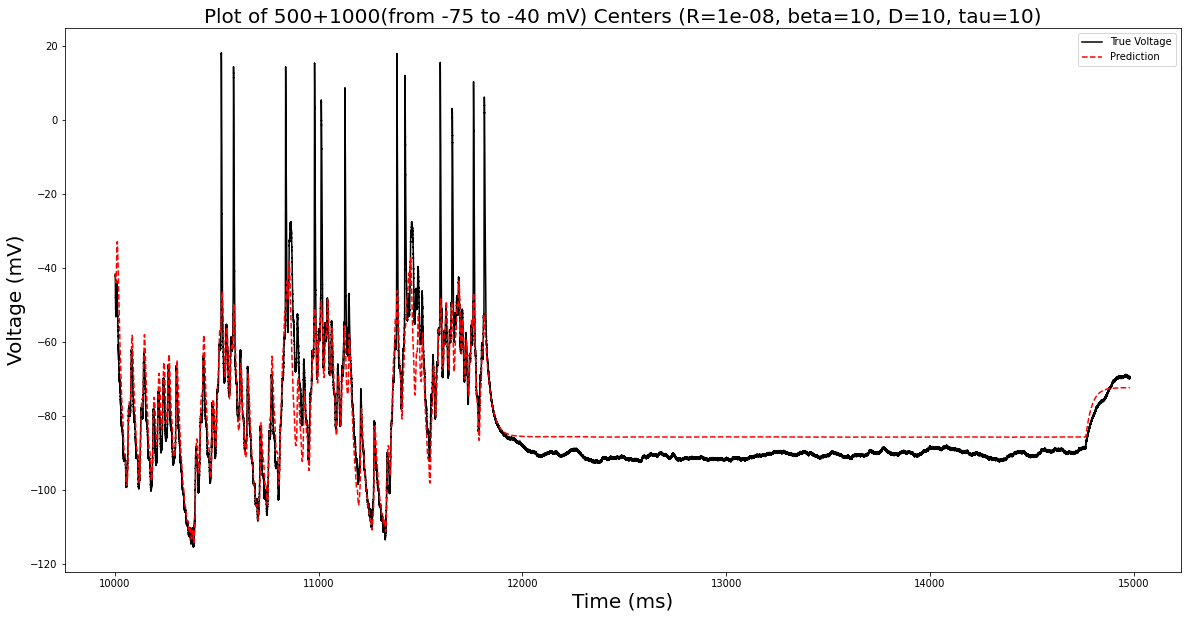

In [218]:
plt.figure(figsize=(20,10))
plt.plot(X,Pdata[bias:bias + PreLength],label = 'True Voltage', color = 'black')
plt.plot(X,PredValidation2[tau*(D-1)+1:tau*(D-1)+PreLength+1],'r--',label = 'Prediction')
plt.xlabel('Time ('+str(Time_units)+')',fontsize=20)
plt.ylabel('Voltage ('+str(Voltage_units)+')',fontsize=20)
plt.legend()
plt.title('Plot of 500+1000(from -75 to -40 mV) Centers (R='+str(R)+', beta='+str(beta)+', D='+str(D)+', tau='+str(tau)+')',fontsize=20)
plt.savefig('500+1000 Centers (R='+str(R)+', beta='+str(beta)+', D='+str(D)+', tau='+str(tau)+')')

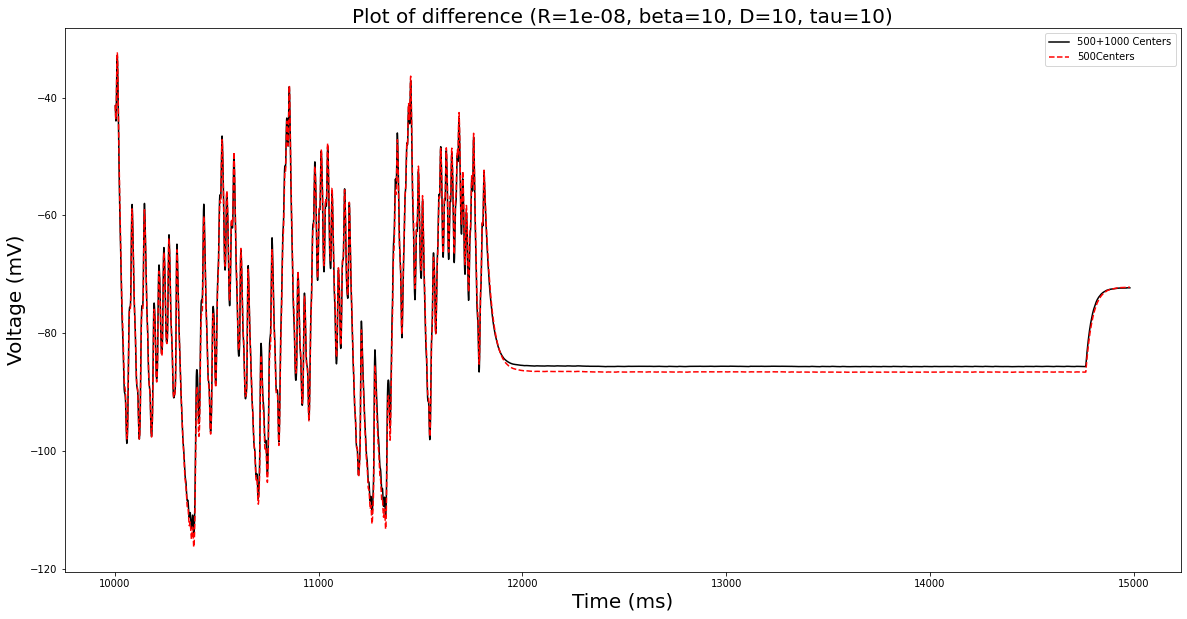

In [216]:
plt.figure(figsize=(20,10))
plt.plot(X,PredValidation2[tau*(D-1)+1:tau*(D-1)+PreLength+1],color = 'black',label = '500+1000 Centers')
plt.plot(X,PredValidation[tau*(D-1)+1:tau*(D-1)+PreLength+1],'r--',label = '500Centers')
plt.xlabel('Time ('+str(Time_units)+')',fontsize=20)
plt.ylabel('Voltage ('+str(Voltage_units)+')',fontsize=20)
plt.legend()
plt.title('Plot of difference (R='+str(R)+', beta='+str(beta)+', D='+str(D)+', tau='+str(tau)+')',fontsize=20)
plt.savefig('Difference (R='+str(R)+', beta='+str(beta)+', D='+str(D)+', tau='+str(tau)+')')

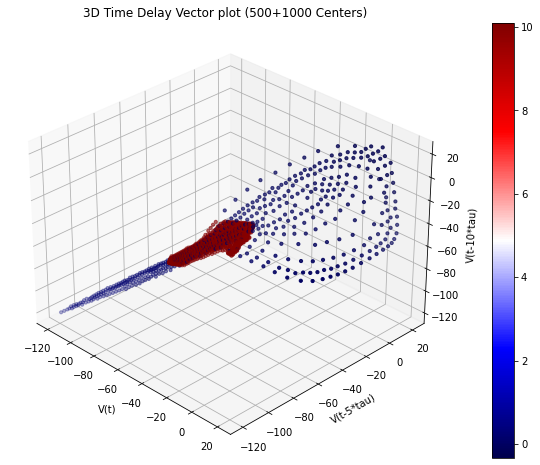

In [215]:
fig=plt.figure(figsize=(18,8))
ax = plt.axes(projection='3d')
weights = DDF.W[:-1]
p=ax.scatter3D(Centers2[:, 0], Centers2[:, 4], Centers2[:, 9], c=weights, cmap=plt.cm.seismic, s=10)
plt.title("3D Time Delay Vector plot (500+1000 Centers)")
ax.set_xlabel("V(t)", fontsize=10)
ax.set_ylabel("V(t-5*tau)", fontsize=10)
ax.set_zlabel("V(t-10*tau)", fontsize=10)
ax.view_init(30,-45)
fig.colorbar(p, ax=ax)
plt.savefig('Weight plot of 500+1000 Centers (R='+str(R)+', beta='+str(beta)+', D='+str(D)+', tau='+str(tau)+')')